In [1]:
%load_ext autoreload
%autoreload 2

import torch
from math import pi
import matplotlib.pyplot as plt
from torchkbnufft import KbNufft

In [2]:
image = torch.randn(1, 1, 64, 64, 64) + 1j * torch.randn(1, 1, 64, 64, 64)
nufft_forward = KbNufft(im_size=(128, 128, 128))

In [3]:
# nufft_forward(image, torch.rand(3, 12) * 2 * pi - pi).shape

In [4]:
from neurorient.reconstruction.slicing import gen_nonuniform_normalized_positions, gen_model_slices

In [5]:
spi_data = torch.load('/pscratch/sd/z/zhantao/neurorient_repo/data/1bxr_train.pt')
print(spi_data.keys())

dict_keys(['orientations', 'images', 'angles', 'points', 'pixel_position_reciprocal', 'volume', 'img_real_mesh', 'vol_real_mesh'])


In [6]:
from neurorient.reconstruction.slicing import get_rho_function

In [7]:
rho = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(spi_data['volume']))).real.clip(0)
rho_func = get_rho_function(spi_data['vol_real_mesh'], rho)
rho_img_coords = torch.from_numpy(rho_func(spi_data['img_real_mesh'].numpy()))

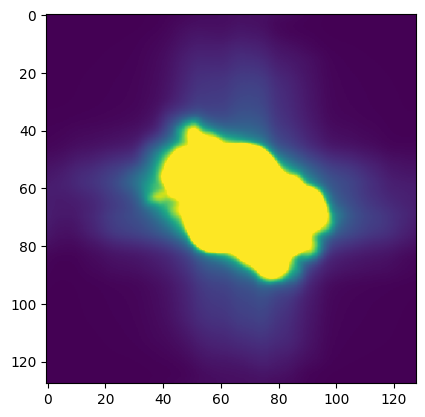

In [8]:
ac = torch.fft.ifftshift(torch.fft.ifftn(torch.fft.fftshift(torch.fft.fftn(rho_img_coords).abs().pow(2))).abs())
plt.imshow(ac[75], vmax=ac.max().item() * 0.01)

In [9]:
slices = gen_model_slices(
    nufft_forward, 
    ac, spi_data['orientations'][:10], spi_data['pixel_position_reciprocal'],
)

In [10]:
slices_ = slices.reshape(10, 128, 128)

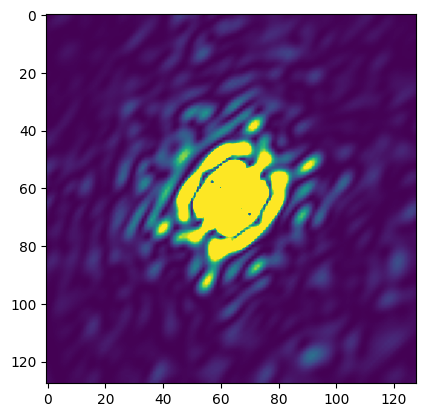

In [11]:
plt.imshow(spi_data['images'][8], vmax=spi_data['images'][8].max() * 1e-3)

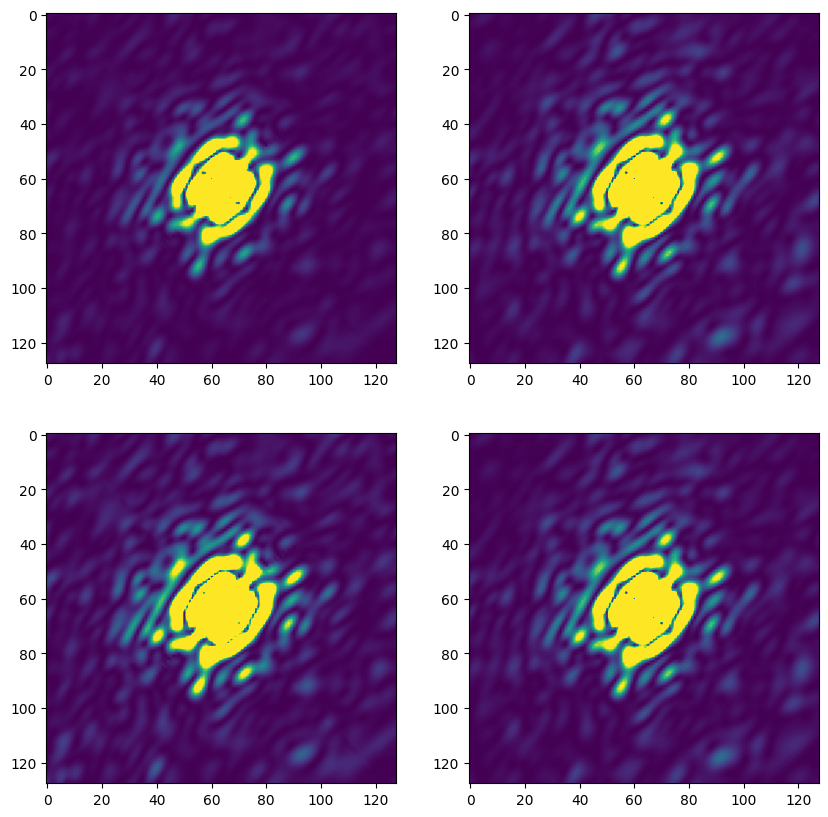

In [12]:
slice1_norm = slices_[8].clip(0) / slices_[8].clip(0).max()
slice2_norm = spi_data['images'][8] / spi_data['images'][8].max()


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(slices_[8].clip(0), vmax=slices_[8].max() * 0.001)
ax[0,1].imshow(spi_data['images'][8], vmax=spi_data['images'][8].max() * 0.001)
ax[1,0].imshow(slice1_norm, vmax=0.0005)
ax[1,1].imshow(slice2_norm, vmax=0.001)
